# TLE Examples

## Objective
- Understand how to use dimensionality reduction techniques (TSNE, UMAP, PCA) to visualize high dimensional data.
- Use such a visualization to suggest a possible classification task.
- Become familiar with the typical workflow of a supervised machine learning problem using a simple neural network.
- Better understand what a NN is doing by visualizing its intermediate layers.


# Dimensionality Reduction Techniques

Many machine learning tasks come with a large number of possible input features. In deep learning, we would like to avoid having to hand-select or engineer features that we think will be useful. Rather, we would prefer the training process have access to the raw data and be able to identify combinations of features we might not have though of.

Nonetheless, there are times in which reducing the number of feature can be helpful.

1. Visualization
2. Reduce the feature space

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import os
from pyorbital import tlefile
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from matplotlib import colors as mcolors

# Load TLE Dataset from CelesTrak

Load TLE datasets downloaded from celestrak

In [2]:
data = []
for tle_fn in glob(os.path.join('data/tle/*.txt')):
    group_name, _ = os.path.splitext(os.path.basename(tle_fn))
    with open(tle_fn, 'r') as fh:
        while True:
            try:
                platform = next(fh)
                line1 = next(fh)
                line2 = next(fh)
                x = tlefile.read(platform, line1=line1, line2=line2)
                data.append({
                    'group' : group_name,
                    'arg_perigee' : x.arg_perigee,
                    'bstar' : x.bstar,
                    'excentricity' : x.excentricity,
                    'inclination' : x.inclination,
                    'mean_anomaly' : x.mean_anomaly,
                    'mean_motion' : x.mean_motion,
                    'mean_motion_derivative' : x.mean_motion_derivative,
                    #'mean_motion_sec_derivative' : x.mean_motion_sec_derivative,
                    'orbit' : x.orbit,
                    'right_ascension' : x.right_ascension
                })
            except StopIteration:
                break       
df = pd.DataFrame(data)

In [3]:
df.sample(n=20)

,arg_perigee,bstar,excentricity,group,inclination,mean_anomaly,mean_motion,mean_motion_derivative,orbit,right_ascension
86,284.7918,0.000000,0.000565,beidou,55.7109,103.3705,1.862324,-3.600000e-07,2112,38.4838
127,359.5001,0.000020,0.008759,cubesat,97.7770,0.6102,14.665157,6.700000e-07,22491,99.8812
1221,12.3471,0.000026,0.019082,nnss,90.3665,52.6840,13.274329,2.100000e-07,47007,289.1475
1627,60.8286,0.000015,0.000049,resource,99.3238,299.2904,13.787157,-2.800000e-07,35492,254.3427
948,192.5722,0.000000,0.003671,gps-ops,54.0479,167.3803,2.005608,5.200000e-07,3317,265.6798
965,97.7767,0.000000,0.000468,intelsat,4.3888,128.2555,1.003663,3.200000e-07,1561,69.1367
2040,232.7444,0.000000,0.000463,weather,3.0241,177.9841,1.002724,-2.130000e-06,3556,69.1050
1536,276.9136,0.000000,0.000269,raduga,12.1166,89.4474,1.003016,-3.410000e-06,9361,318.7094
1962,157.2497,0.000055,0.001300,spire,97.3951,202.9318,15.224512,1.195000e-05,6622,303.8697
1158,141.9747,0.000337,0.693730,military,1.8079,296.5685,2.719952,1.214000e-05,8684,119.8471


## Visualize TLE Data

C:\Users\jpula\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 3 connected components using meta-embedding (experimental)
  n_components


Legend
planet   red
cubesat  blue
geo      yellow
weather  purple
spire    green


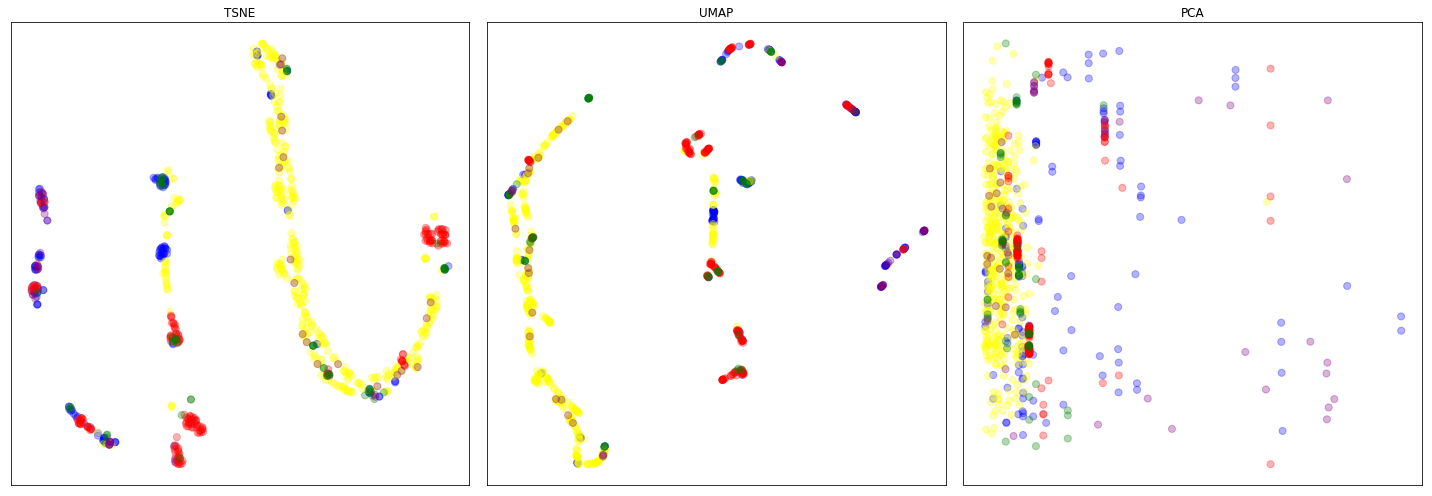

In [99]:
# Get a list of all features except for group
features = df.columns.tolist()
features.remove('group')

# Choose the groups you want to focus on
groups = ['planet', 'cubesat', 'geo', 'weather', 'spire']
#groups = list(df['group'].unique()) # this gives all the groups
#groups = ['planet', 'cubesat']
#groups = ['planet', 'iridium']
#groups = ['planet', 'resource']
df_sub = df[df['group'].isin(groups)]

# Extract values as an array
X = np.array(df_sub[features])
y_str = df_sub['group'].tolist()

# convert y to integers
y = np.array([ groups.index(v) for v in y_str ])

# Fit each embedding
pca_embedding = PCA(n_components=2).fit_transform(X)
tsne_embedding = TSNE(n_components=2).fit_transform(X)
umap_embedding = umap.UMAP().fit_transform(X)

# Choose a color scheme
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = np.random.choice(list(colors.keys()), len(groups), replace=False)
colors = ['red', 'blue', 'yellow', 'purple', 'green', 'pink']
color_legend = dict(zip(groups, colors))
colors = [ color_legend[group] for group in y_str ]

# Plot the Embeddings
embeddings = [
    ('TSNE', tsne_embedding),
    ('UMAP', umap_embedding),
    ('PCA',  pca_embedding)
]
fig, axes = plt.subplots(ncols=len(embeddings), figsize=(20,7))
for ndx, (title, xy) in enumerate(embeddings):
    ax = axes[ndx]
    ax.scatter(xy[:,0], xy[:,1], c=colors, alpha=0.3, s=50)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.tight_layout()

print('Legend')
for group, color in color_legend.items():
    print('{:8} {}'.format(group, color))

These visualizations suggest that we should be able to guess the group field from the TLE data (at least better than random).

# Classification

### Import Libraries

- __keras__: deep learning library for Python (wraps tensorflow and others)
- __sklearn__ : classical machine learning techniques + some nice utilities

In [13]:
import random

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Step 1: Split Data in Train and Test Sets

In [41]:
# Reserve 20% of the data for testing
# Startify the data split so that the train and test sets have the same class distribution

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

print('Generated train and test sets with the following sizes.')
print('Train X (features) {}, y (targets) {}'.format(X_train.shape, y_train.shape))
print('Test  X (features) {}, y (targets) {}'.format(X_test.shape, y_test.shape))

Generated train and test sets with the following sizes.
Train X (features) (712, 9), y (targets) (712,)
Test  X (features) (179, 9), y (targets) (179,)


### Step 2: Choose a metric

In [42]:
metric = 'accuracy'

### Step 3: Choose a model

In [44]:
nb_classes = len(groups)

model = Sequential()
model.add(Dense(units=100,activation='relu', batch_input_shape=(16,9)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=[metric]
)

# keras is complaining that I need to evaluate the model before printing a summary
# model.predict(np.zeros((16,9)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (16, 100)                 1000      
_________________________________________________________________
dense_5 (Dense)              (16, 100)                 10100     
_________________________________________________________________
dense_6 (Dense)              (16, 5)                   505       
Total params: 11,605
Trainable params: 11,605
Non-trainable params: 0
_________________________________________________________________


### Training Step

In [ ]:
repeats = 500
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.

def normalize(X):
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

model.fit(
    normalize(X_train.repeat(repeats, axis=0)),
    y_train.repeat(repeats, axis=0),
    validation_data=(normalize(X_test), y_test),
    epochs=1000,
    batch_size=16,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss')],
    verbose=1
)

### Evaluate Trained Model on Test Data

In [75]:
def plot_confusion_matrix(X,y,title):
    yhat = model.predict(normalize(X))
    cm = confusion_matrix(y, np.argmax(yhat, axis=1))
    a = pd.DataFrame(cm)
    a.columns = groups
    a.index = groups
    sns.heatmap(a, cmap=None, annot=True, linewidths=1).set_title(title)

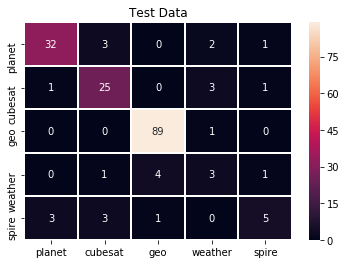

In [76]:
plot_confusion_matrix(X_test, y_test, 'Test Data')

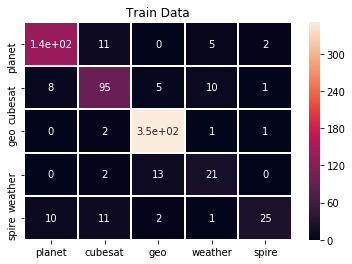

In [77]:
plot_confusion_matrix(X_train, y_train, 'Train Data')

### Visualize Intermediate Layers -- Compare To Original Embeddings

__TODO__ : Add a comparison between the features extracted in an intermediate layer and the dimension reduction visualizations above.

### Test other Hyper-Parameters

In [94]:
def test_model(nb_layers=2, layer_width=100, dropout=True, regularizer=None, activation='relu', batch_size=16):

    # Build the Model
    nb_classes = len(groups)
    model = Sequential()
    for _ in range(nb_layers):
        dense_layer = Dense(
            units=layer_width,
            activation=activation,
            kernel_regularizer=regularizer,
            batch_input_shape=(batch_size,9)
        )
        model.add(dense_layer)
        if dropout:
            model.add(Dropout(0.5))
    model.add(Dense(units=nb_classes, activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy']
    )

    # Train the Model
    repeats = 500
    early_stopping_patience = 3
    history = model.fit(
        normalize(X_train.repeat(repeats, axis=0)),
        y_train.repeat(repeats, axis=0),
        validation_data=(normalize(X_test), y_test),
        epochs=1000,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=early_stopping_patience, monitor='val_loss')],
        verbose=1
    )
    
    # Evaluate the Model
    # Training is setup to stop after val_loss failed to improve for <early_stopping_patience> many steps
    # So, we look back one more than that many steps to find the best score on our test data
    val_acc = history.history['val_acc'][-early_stopping_patience-1]
    
    return val_acc

In [95]:
# Define a space from which to draw random hyperparameters
def sample_config():
    return {
        'nb_layers': random.choice([1,2,3,4]),
        'layer_width': random.choice([10,50,100]),
        'dropout': random.choice([True, False]),
        'regularizer': random.choice([None, regularizers.l2(0.01), regularizers.l1(0.01)]),
        'activation': random.choice(['relu', 'linear', 'sigmoid']),
        'batch_size': random.choice([1,2,4,8,16,32,64])
    }    

# Generate some random sets of hyperparameters
nb_samples = 3
configs = [ sample_config() for _ in range(nb_samples) ]

for config in configs:
    print(config)
    score = test_model(**config)
    print('score = {}'.format(score))

{'nb_layers': 4, 'layer_width': 50, 'dropout': True, 'regularizer': <keras.regularizers.L1L2 object at 0x0000025CC8FA7EF0>, 'activation': 'relu', 'batch_size': 8}
Train on 356000 samples, validate on 179 samples
Epoch 1/1000
356000/356000 [==============================] - 46s 128us/step - loss: 1.3515 - acc: 0.5278 - val_loss: 1.1872 - val_acc: 0.6592
Epoch 2/1000
356000/356000 [==============================] - 45s 126us/step - loss: 1.2480 - acc: 0.5343 - val_loss: 1.2346 - val_acc: 0.5922
Epoch 3/1000
356000/356000 [==============================] - 42s 117us/step - loss: 1.2502 - acc: 0.5281 - val_loss: 1.1667 - val_acc: 0.6425
Epoch 4/1000
356000/356000 [==============================] - 41s 116us/step - loss: 1.2525 - acc: 0.5246 - val_loss: 1.2518 - val_acc: 0.5810
Epoch 5/1000
356000/356000 [==============================] - 45s 127us/step - loss: 1.2534 - acc: 0.5232 - val_loss: 1.2608 - val_acc: 0.5698
Epoch 6/1000
356000/356000 [==============================] - 52s 146us/s